# 9.1 门控循环单元（GRU）
- **目录**
  - 9.1.1 门控隐状态
    - 9.1.1.1 重置门和更新门
    - 9.1.1.2 候选隐状态
    - 9.1.1.3 隐状态
  - 9.1.2 从零开始实现
    - 9.1.2.1 初始化模型参数
    - 9.1.2.2 定义模型
    - 9.1.2.3 训练与预测
  - 9.1.3 简洁实现

- 在 8.7节中，我们讨论了如何在循环神经网络中计算梯度，
以及**矩阵连续乘积**可以导致**梯度消失**或**梯度爆炸**的问题。
- 下面我们简单思考一下这种梯度异常在实践中的意义：
  * 我们可能会遇到这样的情况：**早期观测值对预测所有未来观测值具有非常重要的意义**。
  考虑一个极端情况，其中第一个观测值包含一个校验和，
  目标是在序列的末尾辨别校验和是否正确。
  在这种情况下，第一个词元的影响至关重要。
  我们希望有某些机制能够在一个记忆元里存储重要的早期信息。
  如果没有这样的机制，我们将不得不给这个观测值指定一个非常大的梯度，
  因为它会影响所有后续的观测值。
  * 我们可能会遇到这样的情况：一些词元没有相关的观测值。
  例如，在对网页内容进行情感分析时，
  可能有一些辅助HTML代码与网页传达的情绪无关。
  我们希望有一些机制来**跳过隐状态表示中的此类词元。**
  * 我们可能会遇到这样的情况：序列的各个部分之间存在逻辑中断。
  例如，书的章节之间可能会有过渡存在，
  或者证券的熊市和牛市之间可能会有过渡存在。
  在这种情况下，最好有一种方法来**重置**我们的内部状态表示。

- 已经提出了许多方法来解决这类问题。
  - 其中最早的方法是<b>长短期记忆（long-short-term memory，LSTM）</b>，
我们将在 9.2节中讨论。
  - <b>门控循环单元（gated recurrent unit，GRU） </b>是一个稍微简化的变体，通常能够提供同等的效果，
并且计算的速度明显更快。
  - 门控循环单元更简单，我们从它开始解读。

- **要点：**
  - **梯度问题**：RNN可能遇到梯度消失或梯度爆炸问题。
  - **实践影响**：关键早期信息可能难以保留，无关信息可能干扰学习过程，序列中断点可能需要重置状态。
  - **解决方法**：LSTM和GRU通过门控机制帮助处理长序列，并缓解梯度问题。

----------

- **说明：何为早期观测值对预测所有未来观测值具有非常重要的意义？**
  - 比如：影评文本："这部电影的表演真是太出色了！导演的构图和镜头运用都非常棒。但是剧情有点拖沓，情节发展缓慢。"
  - 在这个例子中，关键词"出色"、"导演"、"棒"、"拖沓"、"情节发展缓慢"等词汇可能对后续内容的情感分析产生重要影响。
  - 这些关键词揭示了影评者对电影不同方面的评价，其中正面的关键词如"出色"和"棒"暗示了他对表演和导演构图的赞赏，而负面的关键词如"拖沓"和"情节发展缓慢"则指出了剧情存在的问题。
  - 在进行情感分析时，希望模型能够捕捉到这些关键词的重要性，因为它们可以提供有价值的线索，帮助判断整个影评的情感倾向。如果模型无法在后续内容中有效地理解这些关键词的含义和重要性，可能会导致情感分析结果不准确。
  - 门控循环单元（GRU）和长短期记忆（LSTM）等循环神经网络模型能够在文本数据中处理这种长程依赖关系，从而更好地捕捉关键词的影响，提高情感分析等自然语言处理任务的性能。
  - LSTM（长短期记忆）和GRU（门控循环单元）都引入了**门控机制**，这些机制允许模型**选择性地存储和遗忘信息**，从而有效地在一个记忆元（细胞状态）里存储重要的早期信息。

----

## 9.1.1 门控隐状态

- 门控循环单元与普通的循环神经网络之间的关键区别在于：
  - 前者支持**隐状态的门控**。
- 这意味着模型有专门的机制来确定应该**何时更新隐状态**，以及应该**何时重置隐状态**。
  - 这些机制是**可学习**的，并且能够解决了上面列出的问题。
  - 例如，如果第一个词元非常重要，模型将学会在第一次观测之后不更新隐状态。
- 同样，模型也可以学会**跳过不相关的临时观测**。
- 最后，模型还将学会在需要的时候重置隐状态。
- 通过门控机制的学习，模型可以自动决定哪些观测值对当前任务或目标有用，哪些观测值可以被忽略，从而提高了序列数据建模的能力。
- 这种跳过不相关的临时观测的能力有助于提高模型的表现，并更有效地处理序列数据。

### 9.1.1.1 重置门和更新门

- 首先介绍<b>重置门（reset gate）</b>和<b>更新门（update gate）</b>。
- 把它们设计成$(0, 1)$区间中的向量，这样就可以进行凸组合。
- **重置门允许我们控制“可能还想记住”的过去状态的数量.**
  - 重置门决定了模型应该<b>“遗忘”多少</b>上一时刻的隐状态信息，即决定哪些旧的信息应该被丢弃，以便在当前时间步接收新的输入信息。
- **更新门将允许我们控制新状态中有多少个是旧状态的副本。**
  - 更新门决定了模型应该<b>“记住”多少</b>上一时刻的隐状态信息，即决定哪些旧的状态信息应该传递到当前时间步的新状态中。
- GRU从构造这些门控开始：
  - 图9.1.1 描述了门控循环单元中的重置门和更新门的输入，**输入是由当前时间步的输入和前一时间步的隐状态给出**。
  - 两个门的输出是由使用sigmoid激活函数的两个全连接层给出。

<center>
    <img src="../img/gru-1.svg" alt="在门控循环单元模型中计算重置门和更新门">
</center>
<center>图9.1.1 在门控循环单元模型中计算重置门和更新门</center><br>

- 看一下门控循环单元的数学表达：
- 对于给定的时间步$t$，假设输入是一个小批量
$\mathbf{X}_t \in \mathbb{R}^{n \times d}$
（样本个数：$n$，输入个数：$d$），
上一个时间步的隐状态是
$\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$
（隐藏单元个数：$h$）。
- 那么，重置门$\mathbf{R}_t \in \mathbb{R}^{n \times h}$和
更新门$\mathbf{Z}_t \in \mathbb{R}^{n \times h}$的计算如下所示：
$$
\begin{aligned}
\mathbf{R}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xr} + \mathbf{H}_{t-1} \mathbf{W}_{hr} + \mathbf{b}_r),\\
\mathbf{Z}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xz} + \mathbf{H}_{t-1} \mathbf{W}_{hz} + \mathbf{b}_z),
\end{aligned} \tag{9.1.1}
$$
  - 其中$\mathbf{W}_{xr}, \mathbf{W}_{xz} \in \mathbb{R}^{d \times h}$和$\mathbf{W}_{hr}, \mathbf{W}_{hz} \in \mathbb{R}^{h \times h}$是权重参数，
  - $\mathbf{b}_r, \mathbf{b}_z \in \mathbb{R}^{1 \times h}$是偏置参数。
请注意，在求和过程中会触发广播机制
（请参阅 2.1.3节）。
  - 使用sigmoid函数（如 4.1节中介绍的）将输入值转换到区间$(0, 1)$。

### 9.1.1.2 候选隐状态
- 接下来，将重置门$\mathbf{R}_t$与公式8.4.5中的常规隐状态更新机制集成，得到在时间步$t$的**候选隐状态（candidate hidden state）**$\tilde{\mathbf{H}}_t \in \mathbb{R}^{n \times h}$:
  $$\tilde{\mathbf{H}}_t = \tanh(\mathbf{X}_t \mathbf{W}_{xh} + \left(\mathbf{R}_t \odot \mathbf{H}_{t-1}\right) \mathbf{W}_{hh} + \mathbf{b}_h) \tag{9.1.2}$$
  - 其中$\mathbf{W}_{xh} \in \mathbb{R}^{d \times h}$
  - $\mathbf{W}_{hh} \in \mathbb{R}^{h \times h}$是权重参数，
  - $\mathbf{b}_h \in \mathbb{R}^{1 \times h}$是偏置项，
  - 符号$\odot$是Hadamard积（按元素乘积）运算符。
  - 在这里使用tanh非线性激活函数来确保候选隐状态中的值保持在区间$(-1, 1)$中。
- 与公式8.4.5相比，公式9.1.2中的$\mathbf{R}_t$和$\mathbf{H}_{t-1}$的元素相乘可以**减少以往状态的影响**。
- 每当重置门$\mathbf{R}_t$中的项接近$1$时，恢复一个如公式8.4.5中的普通的循环神经网络。
  - 即：$\mathbf{H}_t = \phi(\mathbf{X}_t \mathbf{W}_{xh} + \mathbf{H}_{t-1} \mathbf{W}_{hh}  + \mathbf{b}_h)$
- 对于重置门$\mathbf{R}_t$中所有接近$0$的项，候选隐状态是以$\mathbf{X}_t$作为输入的多层感知机的结果。
  - 即：$\tilde{\mathbf{H}}_t \approx \tanh(\mathbf{X}_t \mathbf{W}_{xh}  +\mathbf{b}_h) $
- 因此，任何预先存在的隐状态都会被**重置**为默认值。
- 图9.1.2说明了应用重置门之后的计算流程。
<center>
    <img src="../img/gru-2.svg" alt="在门控循环单元模型中计算候选隐状态">
</center>
<center>
    图9.1.2 在门控循环单元模型中计算候选隐状态
</center>

------

- **说明：何为“任何预先存在的隐状态都会被重置为默认值”？**
  - "任何预先存在的隐状态都会被重置为默认值"是指在GRU中，当重置门 $R_t$ 中的所有项接近 0 时，模型会将上一时刻的隐状态 $H_{t-1}$ 完全忽略，并将候选隐状态 $\tilde{H}_t$ 计算为当前时间步的输入数据 $X_t$ 的多层感知机的结果。
  - 在GRU中，重置门控制了上一时刻隐状态中哪些信息应该被保留或遗忘。如果重置门 $R_t$ 中的所有元素接近 0，意味着模型认为当前时间步的输入 $X_t$ 更重要，而上一时刻的隐状态 $H_{t-1}$ 中的信息对当前状态的影响应该被忽略。
  - 具体来说，当重置门 $R_t$ 中的所有项接近 0 时，候选隐状态的计算公式为：
  $$ \tilde{H}t = \tanh(X_t W{xh} + b_h) $$
  - 在这个情况下，上一时刻的隐状态 $H_{t-1}$ 的信息被完全忽略，候选隐状态仅由当前时间步的输入数据 $X_t$ 决定。因此，这意味着任何预先存在的隐状态（上一时刻的隐状态）都会被重置为默认值（当前时间步的输入数据的多层感知机的结果）。
  - 通过重置门的作用，GRU能够根据当前输入数据动态地选择性地遗忘或保留过去的隐状态信息，从而更好地捕捉序列数据中的重要特征和长期依赖关系。这种灵活性使得GRU在处理各种序列任务时表现优秀。

----------

### 9.1.1.3 隐状态

- 上述的计算结果只是**候选隐状态**，我们仍然需要结合**更新门$\mathbf{Z}_t$的效果**。
- 这一步确定新的隐状态$\mathbf{H}_t \in \mathbb{R}^{n \times h}$
在多大程度上来自旧的状态$\mathbf{H}_{t-1}$和
新的候选状态$\tilde{\mathbf{H}}_t$。
- 更新门$\mathbf{Z}_t$仅需要在
$\mathbf{H}_{t-1}$和$\tilde{\mathbf{H}}_t$
之间进行按元素的凸组合就可以实现这个目标。
- 这就得出了**门控循环单元的最终更新公式**：
$$\mathbf{H}_t = \mathbf{Z}_t \odot \mathbf{H}_{t-1}  + (1 - \mathbf{Z}_t) \odot \tilde{\mathbf{H}}_t \tag{9.1.3}$$
- 每当更新门$\mathbf{Z}_t$接近$1$时，模型就倾向只保留旧状态。
- 此时，来自$\mathbf{X}_t$的信息基本上被忽略，从而有效地跳过了依赖链条中的时间步$t$。
- 相反，当$\mathbf{Z}_t$接近$0$时，新的隐状态$\mathbf{H}_t$就会接近候选隐状态$\tilde{\mathbf{H}}_t$。
- 这些设计可以帮助我们处理循环神经网络中的梯度消失问题，并更好地捕获时间步距离很长的序列的依赖关系。
  - 例如，如果整个子序列的所有时间步的更新门都接近于$1$，则无论序列的长度如何，在序列起始时间步的旧隐状态都将很容易保留并传递到序列结束。
- 图9.1.3说明了更新门起作用后的计算流。
<center>
    <img src="../img/gru-3.svg" alt="计算门控循环单元模型中的隐状态">
</center>
<center>
    图9.1.3 在门控循环单元模型中计算候选隐状态
</center>
- 总之，门控循环单元具有以下两个显著特征：
  * 重置门有助于捕获序列中的短期依赖关系。
  * 更新门有助于捕获序列中的长期依赖关系。

------------

- **说明：GRU模型图示与公式对照说明**
<img src='../img/9_1_3.png'>


----------

## 9.1.2 从零开始实现

- 首先，我们读取 8.5节中使用的时间机器数据集：

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

------------
- **说明：train_iter探析**

In [2]:
## 词表大小
len(vocab), 

(28,)

- train_iter是自定义的数据加载器，其形状为：(8,2,32,35)
  - 8：表示小批量个数；2：表示2个张量，分别代表训练数据与标签；
  - (32, 35)：表示每个小批量的大小与时间步数。

  - train_iter的具体形式：list[8*tuple(tensor[32,35],tensor[32,35])]

<img src='..\img\9_1_1.png' height=450 width=450>

In [3]:
'''
训练集是一个(8,2,32,35)形状的数据集。
该训练集不是张量，而是一个迭代生成器。
包含8个tuple；每个tuple里有2个张量。
每个张量是(32, 35)的矩阵。
'''
list(iter(train_iter))

[(tensor([[ 1, 21, 19,  ...,  1, 16,  7],
          [12,  2,  8,  ..., 10,  1, 18],
          [10,  2, 16,  ...,  5, 10,  2],
          ...,
          [ 1,  3,  2,  ...,  1,  8,  2],
          [ 8,  7, 13,  ...,  3,  4,  6],
          [21, 12,  2,  ...,  9,  2,  1]]),
  tensor([[21, 19,  1,  ..., 16,  7, 10],
          [ 2,  8,  1,  ...,  1, 18, 12],
          [ 2, 16,  5,  ..., 10,  2, 11],
          ...,
          [ 3,  2, 12,  ...,  8,  2,  2],
          [ 7, 13,  2,  ...,  4,  6, 15],
          [12,  2,  1,  ...,  2,  1, 11]])),
 (tensor([[10,  1,  8,  ...,  2,  4, 23],
          [12,  4,  8,  ...,  6,  3,  8],
          [11,  1,  9,  ..., 20,  4, 10],
          ...,
          [ 2,  6,  1,  ...,  5,  6,  5],
          [15,  2,  1,  ..., 10,  1,  3],
          [11, 10,  2,  ...,  1,  7,  6]]),
  tensor([[ 1,  8,  7,  ...,  4, 23,  1],
          [ 4,  8,  8,  ...,  3,  8,  1],
          [ 1,  9,  5,  ...,  4, 10,  4],
          ...,
          [ 6,  1,  4,  ...,  6,  5,  8],
         

In [4]:
## 每次迭代一个tuple：训练集与标签集
for a,b in train_iter:
    print('训练集：', a)
    print('标签集:', b)
    break

训练集： tensor([[17,  2, 12,  ...,  5,  3,  1],
        [ 1, 16, 12,  ...,  8,  1,  7],
        [ 1,  4,  8,  ...,  1,  2,  4],
        ...,
        [ 1,  4, 21,  ...,  1, 21, 14],
        [ 6,  8, 20,  ..., 11,  1,  6],
        [12,  4, 15,  ..., 14, 20,  1]])
标签集: tensor([[ 2, 12, 12,  ...,  3,  1, 17],
        [16, 12,  4,  ...,  1,  7, 14],
        [ 4,  8,  1,  ...,  2,  4, 10],
        ...,
        [ 4, 21,  7,  ..., 21, 14, 10],
        [ 8, 20,  4,  ...,  1,  6,  7],
        [ 4, 15,  2,  ..., 20,  1,  4]])


------------

### 9.1.2.1 初始化模型参数

- 下一步是初始化模型参数：
  - 从标准差为$0.01$的高斯分布中提取权重。
  - 并将偏置项设为$0$，超参数`num_hiddens`定义隐藏单元的数量。
  - 实例化与更新门、重置门、候选隐状态和输出层相关的所有权重和偏置。


In [5]:
def get_params(vocab_size, num_hiddens, device):
    '''
    num_inputs = num_outputs = 28
    '''
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    def three():
        ## 1：(28,256)
        ## 2: (256,256)
        ## 3: (256,)
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    ## 形状依次为：(28,256), (256,256), (256,)
    W_xz, W_hz, b_z = three()  # 更新门参数
    W_xr, W_hr, b_r = three()  # 重置门参数
    W_xh, W_hh, b_h = three()  # 候选隐状态参数
    # 输出层参数,(256,28), (28,)
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

### 9.1.2.2 定义模型

- 现在**定义隐状态的初始化函数**`init_gru_state`。
- 与 8.5节中定义的`init_rnn_state`函数一样：
  - 函数返回一个形状为（批量大小，隐藏单元个数）的张量。
  - 张量的值全部为零。


In [6]:
# return:(32, 256)
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

- 现在准备**定义门控循环单元模型**
  - 模型的架构与基本的循环神经网络单元是相同的，只是权重更新公式更为复杂。


In [7]:
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    '''
    inputs的形状：(35, 32, 28)。
    训练集的原本是8个(32,35)形状的张量，在RNNModel里进行转置变成(35, 32)，
    然后再依据词表vacob的长度进行独热编码，vacob的长度是28，因此X变成8个(35, 32, 28)形状的数据。
    然后每个inputs是8个(35, 32, 28)中的一个。
    '''
    for X in inputs:
        '''
        Z, R, H_tilda的形状为：[(32,28)@(28,256)=(32,256)]+[(32,256)@(256,256)=(32,256)]+(256,1)
        =(32,256)。
        对于结果，前两者使用sigmoid激活函数；第3个使用tanh激活函数。
        '''
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        '''
        H形状：(32,256)*(32,256)+[(1-Z):(32,256)]*(32,256)=(32,256)
        '''
        H = Z * H + (1 - Z) * H_tilda
        '''
        Y = (32,256)@(256,28)+(28)=(32,28)
        值得注意的是，这是自定义gru的实现方式。
        与之相对应，在简洁实现里是通过一个全连接层进行计算的。
        可以查看d2l_torch文件里的RNNModel代码。
        '''
        Y = H @ W_hq + b_q
        outputs.append(Y)
        '''
        Y最后还要通过cat进行连接，最后的形状是(35*32,28)=(1120,28)。
        这是一个小批量的计算结果。
        '''
    return torch.cat(outputs, dim=0), (H,)

In [18]:
import numpy as np
a = np.array([1,2,3,4])
b = np.array([5,6,7,8])
h, = (a,)
h

array([1, 2, 3, 4])

### 9.1.2.3 训练与预测

- 训练和预测的工作方式与8.5节完全相同。
  - 训练结束后，我们分别打印输出训练集的困惑度，
  - 以及前缀“time traveler”和“traveler”的预测序列上的困惑度。


perplexity 1.0, 12219.8 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


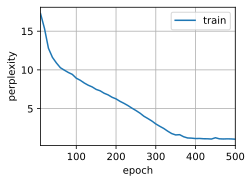

In [8]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                            init_gru_state, gru)
# train_ch8处理迭代epoch，然后在每个epoch里调用train_epoch_ch8
# train_epoch_ch8处理每个epoch里的训练工作
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

In [11]:
device, type(device)

(device(type='cuda', index=0), torch.device)

## 9.1.3 简洁实现

- 高级API包含了前文介绍的所有配置细节，可以直接实例化门控循环单元模型。
- 这段代码的运行速度要快得多，因为它使用的是编译好的运算符而不是Python来处理之前阐述的许多细节。


perplexity 1.0, 116362.0 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


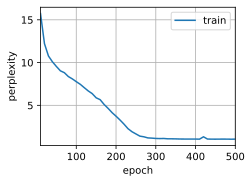

In [9]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = d2l.RNNModel(gru_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

----------------
- **说明：GRU参数和输出的形状**

perplexity 9.5, 22404.0 tokens/sec on cpu
time traveller and the the the the the the the the the the the t
traveller and the the the the the the the the the the the t


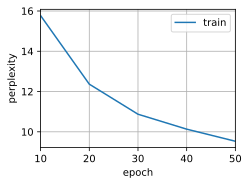

In [13]:
vocab_size, num_hiddens, device = len(vocab), 256, torch.device('cpu')
num_epochs, lr = 50, 1
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model_gru = d2l.RNNModel(gru_layer, len(vocab))
d2l.train_ch8(model_gru, train_iter, vocab, lr, num_epochs, device)

In [14]:
'''
torch.nn.GRU的输出是(N,L,H_out)，即(35,32,256)
但是GRU作为RNNModel中的rnn层，后面还有一个全连接层Linear，
将(35,32,256)变形为(35*32,28)，也就是(1120, 28)的形状。
自定义的gru函数只不过是将上述两个步骤合二为一了。
'''
import torch.nn.functional as F
state_init=torch.zeros((1,32, 256))
X=list(iter(train_iter))[0][0].T
X=F.one_hot(X, 28).type(torch.float32)
outputs,h_state=gru_layer(X,state_init)
'''
输出形状的确是(序列长度,批量大小,隐状态单元数)。
注意这2个参数很重要，后面自然语言处理都是围绕这两个参数运行。
包括Transformer的编码器和解码器。
'''
outputs.shape,h_state.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [15]:
'''
h_state是outputs的最后一个张量，这就比较好理解了.
outputs保存所有时间步的隐状态，H1,H2,...Ht, 而h_state只保存Ht。
'''
torch.all(outputs[34]==h_state)

tensor(True)

- 官方文档：https://pytorch.org/docs/stable/generated/torch.nn.GRU.html#torch.nn.GRU
<img src='..\img\9_1_2.png' height=550 width=550>

In [16]:
'''
RNNModel的foward函数将rnn与全连接层合二为一，输出结果的形状
与自定义gru一致。
只不过隐状态输出有细微差别：自定义gru将其放在一个tuple里输出，
而RNNModel将其作为一个三维张量输出：前者为([32,256],),类型为tuple；
后者为(1, 32, 256)，类型是一个torch.Tensor。
'''
state_init=torch.zeros((1,32, 256))
X=list(iter(train_iter))[0][0]
outputs,h_state=model_gru(X,state_init)
## 上下两种调用方式一致。
#outputs,h_state=model_gru.forward(X,state_init)
outputs.shape,h_state.shape

(torch.Size([1120, 28]), torch.Size([1, 32, 256]))

In [17]:
type(h_state)

torch.Tensor

--------------

## 小结

* 门控循环神经网络可以更好地捕获时间步距离很长的序列上的依赖关系。
* 重置门有助于捕获序列中的短期依赖关系。
* 更新门有助于捕获序列中的长期依赖关系。
* 重置门打开时，门控循环单元包含基本循环神经网络；更新门打开时，门控循环单元可以跳过子序列。